<a href="https://www.kaggle.com/code/tousifbnn/oasis-alzheimer-s-detection-cnn?scriptVersionId=236117271" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Balanced dataset size: 1952


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


Epoch [1/10]
Train Loss: 0.1925, Train Accuracy: 92.89%
Epoch [2/10]
Train Loss: 0.0192, Train Accuracy: 99.30%
Noisy Val Loss: 0.0006, Noisy Val Accuracy: 100.00%
Clean Val Loss: 0.0006, Clean Val Accuracy: 100.00%
Epoch [3/10]
Train Loss: 0.0248, Train Accuracy: 99.42%
Epoch [4/10]
Train Loss: 0.0176, Train Accuracy: 99.74%
Noisy Val Loss: 0.0009, Noisy Val Accuracy: 100.00%
Clean Val Loss: 0.0009, Clean Val Accuracy: 100.00%
Epoch [5/10]
Train Loss: 0.0016, Train Accuracy: 100.00%
Epoch [6/10]
Train Loss: 0.0008, Train Accuracy: 100.00%
Noisy Val Loss: 0.0003, Noisy Val Accuracy: 100.00%
Clean Val Loss: 0.0003, Clean Val Accuracy: 100.00%
Epoch [7/10]
Train Loss: 0.0009, Train Accuracy: 100.00%
Epoch [8/10]
Train Loss: 0.0007, Train Accuracy: 100.00%
Noisy Val Loss: 0.0003, Noisy Val Accuracy: 100.00%
Clean Val Loss: 0.0003, Clean Val Accuracy: 100.00%
Epoch [9/10]
Train Loss: 0.0006, Train Accuracy: 100.00%
Epoch [10/10]
Train Loss: 0.0007, Train Accuracy: 100.00%
Noisy Val Loss: 0

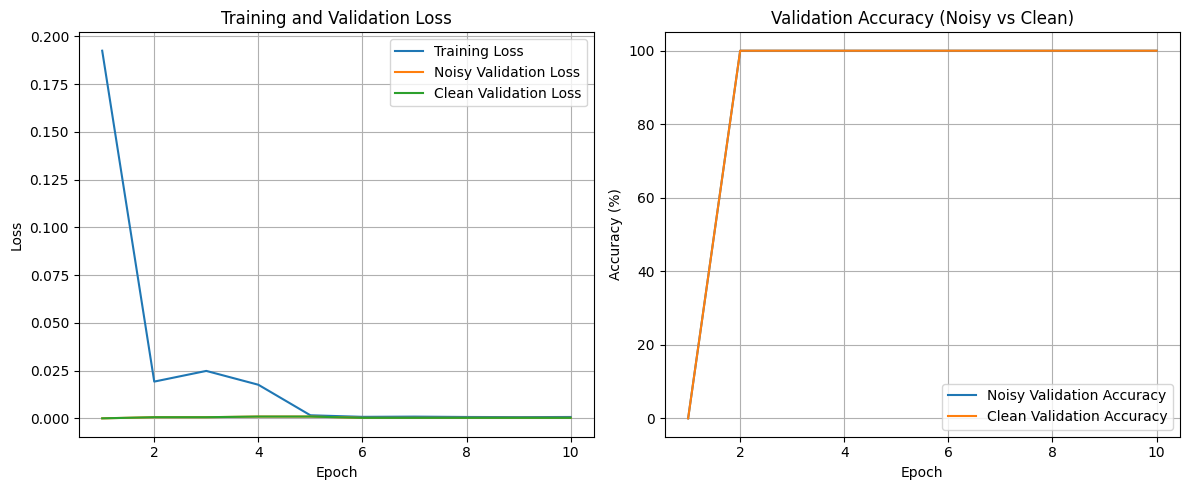

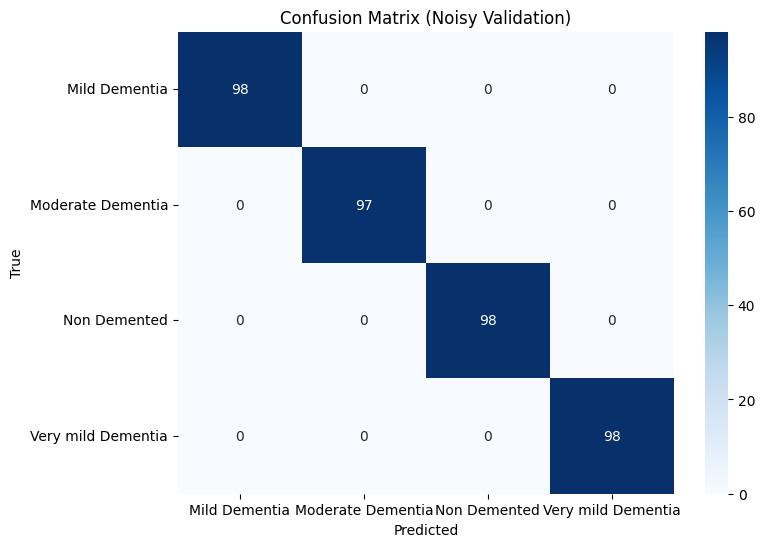


Classification Report (Noisy Validation):
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00        98
 Moderate Dementia       1.00      1.00      1.00        97
      Non Demented       1.00      1.00      1.00        98
Very mild Dementia       1.00      1.00      1.00        98

          accuracy                           1.00       391
         macro avg       1.00      1.00      1.00       391
      weighted avg       1.00      1.00      1.00       391



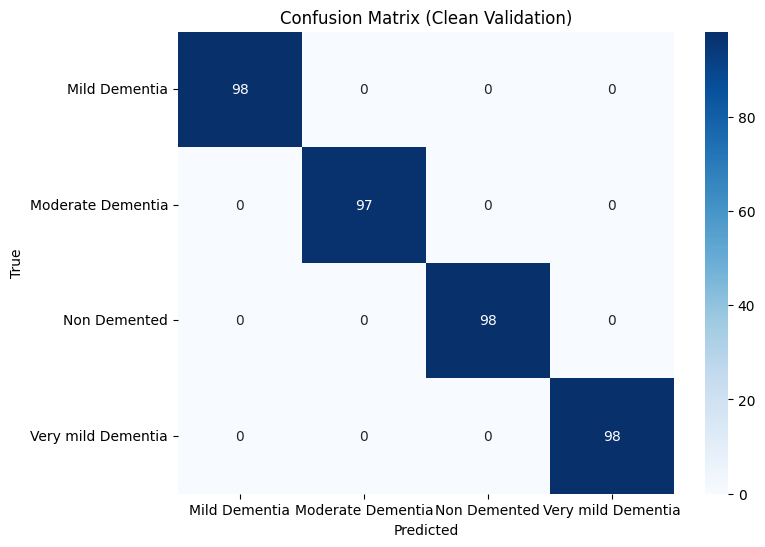


Classification Report (Clean Validation):
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00        98
 Moderate Dementia       1.00      1.00      1.00        97
      Non Demented       1.00      1.00      1.00        98
Very mild Dementia       1.00      1.00      1.00        98

          accuracy                           1.00       391
         macro avg       1.00      1.00      1.00       391
      weighted avg       1.00      1.00      1.00       391



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Copy dataset to working directory for faster I/O
data_dir = '/kaggle/input/imagesoasis/Data'
working_dir = '/kaggle/working/oasis_data'
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
data_dir = working_dir

# Custom transform to add Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return torch.clamp(tensor + noise, min=-1, max=1)  # Clamp to normalized range [-1, 1]

# Transforms for training (with noise and augmentation)
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Transform for noisy validation
transform_val_noisy = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Transform for clean validation
transform_val_clean = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset without transform initially
original_dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = original_dataset.classes
class_to_idx = original_dataset.class_to_idx

# Use all 4 classes
num_classes = len(class_names)
print("Classes:", class_names)
assert num_classes == 4, f"Expected 4 classes, got {num_classes}"

# Balance the dataset (488 images per class)
indices_per_class = {i: [] for i in range(num_classes)}
for idx, label in enumerate(original_dataset.targets):
    indices_per_class[label].append(idx)

# Take 488 samples per class
balanced_indices = []
balanced_labels = []
for label in range(num_classes):
    selected_indices = indices_per_class[label][:488]
    balanced_indices.extend(selected_indices)
    balanced_labels.extend([label] * len(selected_indices))

print("Balanced dataset size:", len(balanced_indices))

# Split dataset
train_idx, val_idx = train_test_split(
    list(range(len(balanced_indices))),
    test_size=0.2, stratify=balanced_labels, random_state=42
)

train_indices = [balanced_indices[i] for i in train_idx]
val_indices = [balanced_indices[i] for i in val_idx]

# Create datasets
train_dataset = torch.utils.data.Subset(original_dataset, train_indices)
val_dataset_noisy = torch.utils.data.Subset(original_dataset, val_indices)
val_dataset_clean = torch.utils.data.Subset(original_dataset, val_indices)

# Apply transforms
train_dataset.dataset.transform = transform_train
val_dataset_noisy.dataset.transform = transform_val_noisy
val_dataset_clean.dataset.transform = transform_val_clean

# Data loaders
batch_size = 32
num_workers = 4
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)
val_loader_noisy = DataLoader(
    val_dataset_noisy, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)
val_loader_clean = DataLoader(
    val_dataset_clean, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training
num_epochs = 10
train_losses = []
val_losses_noisy = []
val_accuracies_noisy = []
val_losses_clean = []
val_accuracies_clean = []

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    
    # Validate on noisy data every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        val_correct_noisy = 0
        val_total_noisy = 0
        val_loss_noisy = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader_noisy:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                val_total_noisy += labels.size(0)
                val_correct_noisy += (predicted == labels).sum().item()
                val_loss_noisy += loss.item()
        
        val_loss_noisy = val_loss_noisy / len(val_loader_noisy)
        val_accuracy_noisy = 100 * val_correct_noisy / val_total_noisy
        val_losses_noisy.append(val_loss_noisy)
        val_accuracies_noisy.append(val_accuracy_noisy)
    else:
        val_losses_noisy.append(val_losses_noisy[-1] if val_losses_noisy else 0)
        val_accuracies_noisy.append(val_accuracies_noisy[-1] if val_accuracies_noisy else 0)
    
    # Validate on clean data every 2 epochs
    if (epoch + 1) % 2 == 0:
        val_correct_clean = 0
        val_total_clean = 0
        val_loss_clean = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader_clean:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                val_total_clean += labels.size(0)
                val_correct_clean += (predicted == labels).sum().item()
                val_loss_clean += loss.item()
        
        val_loss_clean = val_loss_clean / len(val_loader_clean)
        val_accuracy_clean = 100 * val_correct_clean / val_total_clean
        val_losses_clean.append(val_loss_clean)
        val_accuracies_clean.append(val_accuracy_clean)
    else:
        val_losses_clean.append(val_losses_clean[-1] if val_losses_clean else 0)
        val_accuracies_clean.append(val_accuracies_clean[-1] if val_accuracies_clean else 0)
    
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    if (epoch + 1) % 2 == 0:
        print(f'Noisy Val Loss: {val_loss_noisy:.4f}, Noisy Val Accuracy: {val_accuracy_noisy:.2f}%')
        print(f'Clean Val Loss: {val_loss_clean:.4f}, Clean Val Accuracy: {val_accuracy_clean:.2f}%')

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_noisy, label='Noisy Validation Loss')
plt.plot(range(1, num_epochs + 1), val_losses_clean, label='Clean Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies_noisy, label='Noisy Validation Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies_clean, label='Clean Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy (Noisy vs Clean)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history_resnet18_4classes_noisy.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix and class-wise metrics (Noisy)
model.eval()
all_preds_noisy = []
all_labels_noisy = []

with torch.no_grad():
    for images, labels in val_loader_noisy:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_noisy.extend(predicted.cpu().numpy())
        all_labels_noisy.extend(labels.cpu().numpy())

# Confusion matrix (Noisy)
cm_noisy = confusion_matrix(all_labels_noisy, all_preds_noisy)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Noisy Validation)')
plt.savefig('confusion_matrix_resnet18_4classes_noisy.png', dpi=300, bbox_inches='tight')
plt.show()

# Class-wise metrics (Noisy)
print("\nClassification Report (Noisy Validation):")
print(classification_report(all_labels_noisy, all_preds_noisy, target_names=class_names))

# Confusion matrix and class-wise metrics (Clean)
all_preds_clean = []
all_labels_clean = []

with torch.no_grad():
    for images, labels in val_loader_clean:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_clean.extend(predicted.cpu().numpy())
        all_labels_clean.extend(labels.cpu().numpy())

# Confusion matrix (Clean)
cm_clean = confusion_matrix(all_labels_clean, all_preds_clean)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Clean Validation)')
plt.savefig('confusion_matrix_resnet18_4classes_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# Class-wise metrics (Clean)
print("\nClassification Report (Clean Validation):")
print(classification_report(all_labels_clean, all_preds_clean, target_names=class_names))

# Save model
torch.save(model.state_dict(), 'resnet18_alzheimer_4classes_noisy.pth')